# MDI343 Data Challenge

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import itertools

from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

## Chargement des données

In [2]:
data = pd.read_csv('train15_telecom.bz2', sep=' ', compression='bz2', header=0, names=['Target', 'Algo0', 'Algo1', 'Algo2', 'Algo3', 'Algo4', 'Algo5', 'Algo6', 'Algo7', 'Algo8', 'Algo9', 'Algo10', 'Algo11', 'Algo12', 'Algo13'], na_values='-inf')

In [3]:
print('Nombre d\'observations :', data.shape[0])

Nombre d'observations : 2048852


On vérifie s'il y a des valeurs manquantes. Le cas échéant, s'il y en a très peu, on les retire.

In [4]:
data.isna().sum()

Target     0
Algo0      0
Algo1     10
Algo2      0
Algo3     10
Algo4      0
Algo5     10
Algo6      0
Algo7     10
Algo8      0
Algo9     10
Algo10     0
Algo11    10
Algo12     0
Algo13    13
dtype: int64

In [5]:
data.dropna(inplace=True)
print('Nombre d\'observations après nettoyage :', data.shape[0])

Nombre d'observations après nettoyage : 2048839


## Analyse exploratoire des données

In [6]:
X = data.drop(['Target'], axis=1)
y = data['Target']

In [7]:
X.describe()

Algo0         Algo1         Algo2         Algo3         Algo4  \
count  2.048839e+06  2.048839e+06  2.048839e+06  2.048839e+06  2.048839e+06   
mean   2.573611e+03  2.733486e+03  2.569327e+03  2.727718e+03  2.637300e+03   
std    7.418982e+02  7.974587e+02  7.693132e+02  7.846829e+02  6.980120e+02   
min    8.004000e+01 -8.527270e+03  1.802900e+02 -5.867700e+03  5.351000e+01   
25%    2.138500e+03  2.232240e+03  2.149470e+03  2.249000e+03  2.229640e+03   
50%    2.386910e+03  2.592150e+03  2.392620e+03  2.599970e+03  2.460330e+03   
75%    2.772650e+03  3.082760e+03  2.747730e+03  3.053190e+03  2.823075e+03   
max    7.917510e+03  6.519120e+03  9.308740e+03  7.049270e+03  7.830500e+03   

              Algo5         Algo6         Algo7         Algo8         Algo9  \
count  2.048839e+06  2.048839e+06  2.048839e+06  2.048839e+06  2.048839e+06   
mean   2.829041e+03  2.664979e+03  2.863116e+03  2.472302e+03  2.610539e+03   
std    7.413397e+02  7.468085e+02  7.142928e+02  7.094330e+02  7.465425e+02   
min   -9.846110e+03  1.002070e+03 -2.503200e+02  8.172000e+02 -9.182300e+02   
25%    2.368925e+03  2.265550e+03  2.421240e+03  2.072810e+03  2.130070e+03   
50%    2.691370e+03  2.490080e+03  2.730730e+03  2.325930e+03  2.507390e+03   
75%    3.141780e+03  2.827520e+03  3.146935e+03  2.670540e+03  2.959860e+03   
max    6.482930e+03  9.475980e+03  7.107590e+03  8.637100e+03  6.804020e+03   

             Algo10        Algo11        Algo12        Algo13  
count  2.048839e+06  2.048839e+06  2.048839e+06  2.048839e+06  
mean   2.310921e+03  2.378374e+03  2.638926e+03  2.817326e+03  
std    7.412771e+02  7.689533e+02  8.320933e+02  7.518725e+02  
min    1.244010e+03  4.579500e+02  9.310700e+02 -4.910000e+02  
25%    1.921370e+03  1.881610e+03  2.227810e+03  2.366240e+03  
50%    2.142370e+03  2.238160e+03  2.450320e+03  2.678010e+03  
75%    2.457520e+03  2.687620e+03  2.775990e+03  3.086690e+03  
max    1.027537e+04  7.372830e+03  1.118469e+04  7.650540e+03

On peut déjà remarquer sur ce premier tableau que les algorithmes semblent se regrouper en deux types : l'un autorisant les scores négatifs (les algorithmes impairs), l'autre non (les algorithmes pairs). Commençons donc par visualiser leurs distributions respectives.

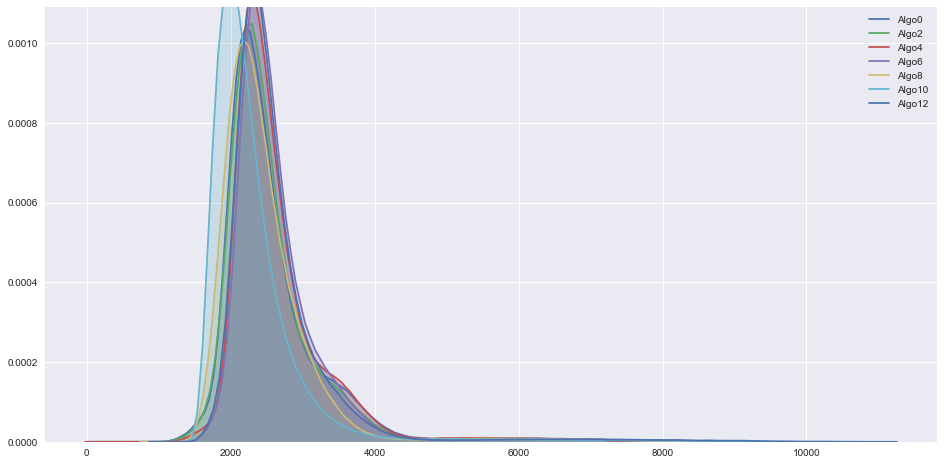

In [8]:
# Algorithmes pairs
plt.figure(figsize=(16, 8))
sns.kdeplot(X['Algo0'], shade=True)
sns.kdeplot(X['Algo2'], shade=True)
sns.kdeplot(X['Algo4'], shade=True)
sns.kdeplot(X['Algo6'], shade=True)
sns.kdeplot(X['Algo8'], shade=True)
sns.kdeplot(X['Algo10'], shade=True)
sns.kdeplot(X['Algo12'], shade=True)
plt.show()

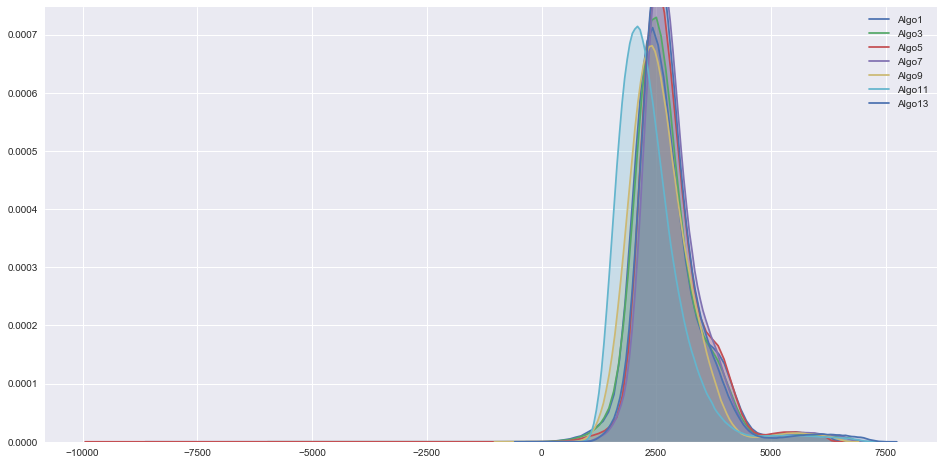

In [9]:
# Algorithmes impairs
plt.figure(figsize=(16, 8))
sns.kdeplot(X['Algo1'], shade=True)
sns.kdeplot(X['Algo3'], shade=True)
sns.kdeplot(X['Algo5'], shade=True)
sns.kdeplot(X['Algo7'], shade=True)
sns.kdeplot(X['Algo9'], shade=True)
sns.kdeplot(X['Algo11'], shade=True)
sns.kdeplot(X['Algo13'], shade=True)
plt.show()

Examinons maintenant la corrélation entre chaque algorithme.

In [10]:
X.corr()

Algo0     Algo1     Algo2     Algo3     Algo4     Algo5     Algo6  \
Algo0   1.000000  0.963007  0.901178  0.859614  0.958802  0.912637  0.925864   
Algo1   0.963007  1.000000  0.830096  0.852327  0.914210  0.940780  0.854667   
Algo2   0.901178  0.830096  1.000000  0.960596  0.909829  0.839855  0.889672   
Algo3   0.859614  0.852327  0.960596  1.000000  0.869463  0.865609  0.818410   
Algo4   0.958802  0.914210  0.909829  0.869463  1.000000  0.959840  0.920589   
Algo5   0.912637  0.940780  0.839855  0.865609  0.959840  1.000000  0.846789   
Algo6   0.925864  0.854667  0.889672  0.818410  0.920589  0.846789  1.000000   
Algo7   0.911489  0.892077  0.843581  0.824650  0.902686  0.878230  0.969762   
Algo8   0.848301  0.769886  0.855045  0.782529  0.847744  0.768531  0.858161   
Algo9   0.805789  0.774555  0.792666  0.771399  0.803137  0.769888  0.786835   
Algo10  0.791867  0.690739  0.799586  0.697989  0.797148  0.697317  0.824743   
Algo11  0.752267  0.692956  0.735592  0.680712  0.757035  0.698048  0.758843   
Algo12  0.880072  0.785571  0.915184  0.831677  0.884227  0.790493  0.898473   
Algo13  0.864818  0.821385  0.885387  0.863029  0.868405  0.824589  0.852397   

           Algo7     Algo8     Algo9    Algo10    Algo11    Algo12    Algo13  
Algo0   0.911489  0.848301  0.805789  0.791867  0.752267  0.880072  0.864818  
Algo1   0.892077  0.769886  0.774555  0.690739  0.692956  0.785571  0.821385  
Algo2   0.843581  0.855045  0.792666  0.799586  0.735592  0.915184  0.885387  
Algo3   0.824650  0.782529  0.771399  0.697989  0.680712  0.831677  0.863029  
Algo4   0.902686  0.847744  0.803137  0.797148  0.757035  0.884227  0.868405  
Algo5   0.878230  0.768531  0.769888  0.697317  0.698048  0.790493  0.824589  
Algo6   0.969762  0.858161  0.786835  0.824743  0.758843  0.898473  0.852397  
Algo7   1.000000  0.800705  0.774984  0.743517  0.721813  0.827957  0.833691  
Algo8   0.800705  1.000000  0.967517  0.728149  0.638787  0.853931  0.800146  
Algo9   0.774984  0.967517  1.000000  0.618025  0.563204  0.765070  0.759425  
Algo10  0.743517  0.728149  0.618025  1.000000  0.960971  0.826664  0.744709  
Algo11  0.721813  0.638787  0.563204  0.960971  1.000000  0.741261  0.706430  
Algo12  0.827957  0.853931  0.765070  0.826664  0.741261  1.000000  0.962385  
Algo13  0.833691  0.800146  0.759425  0.744709  0.706430  0.962385  1.000000

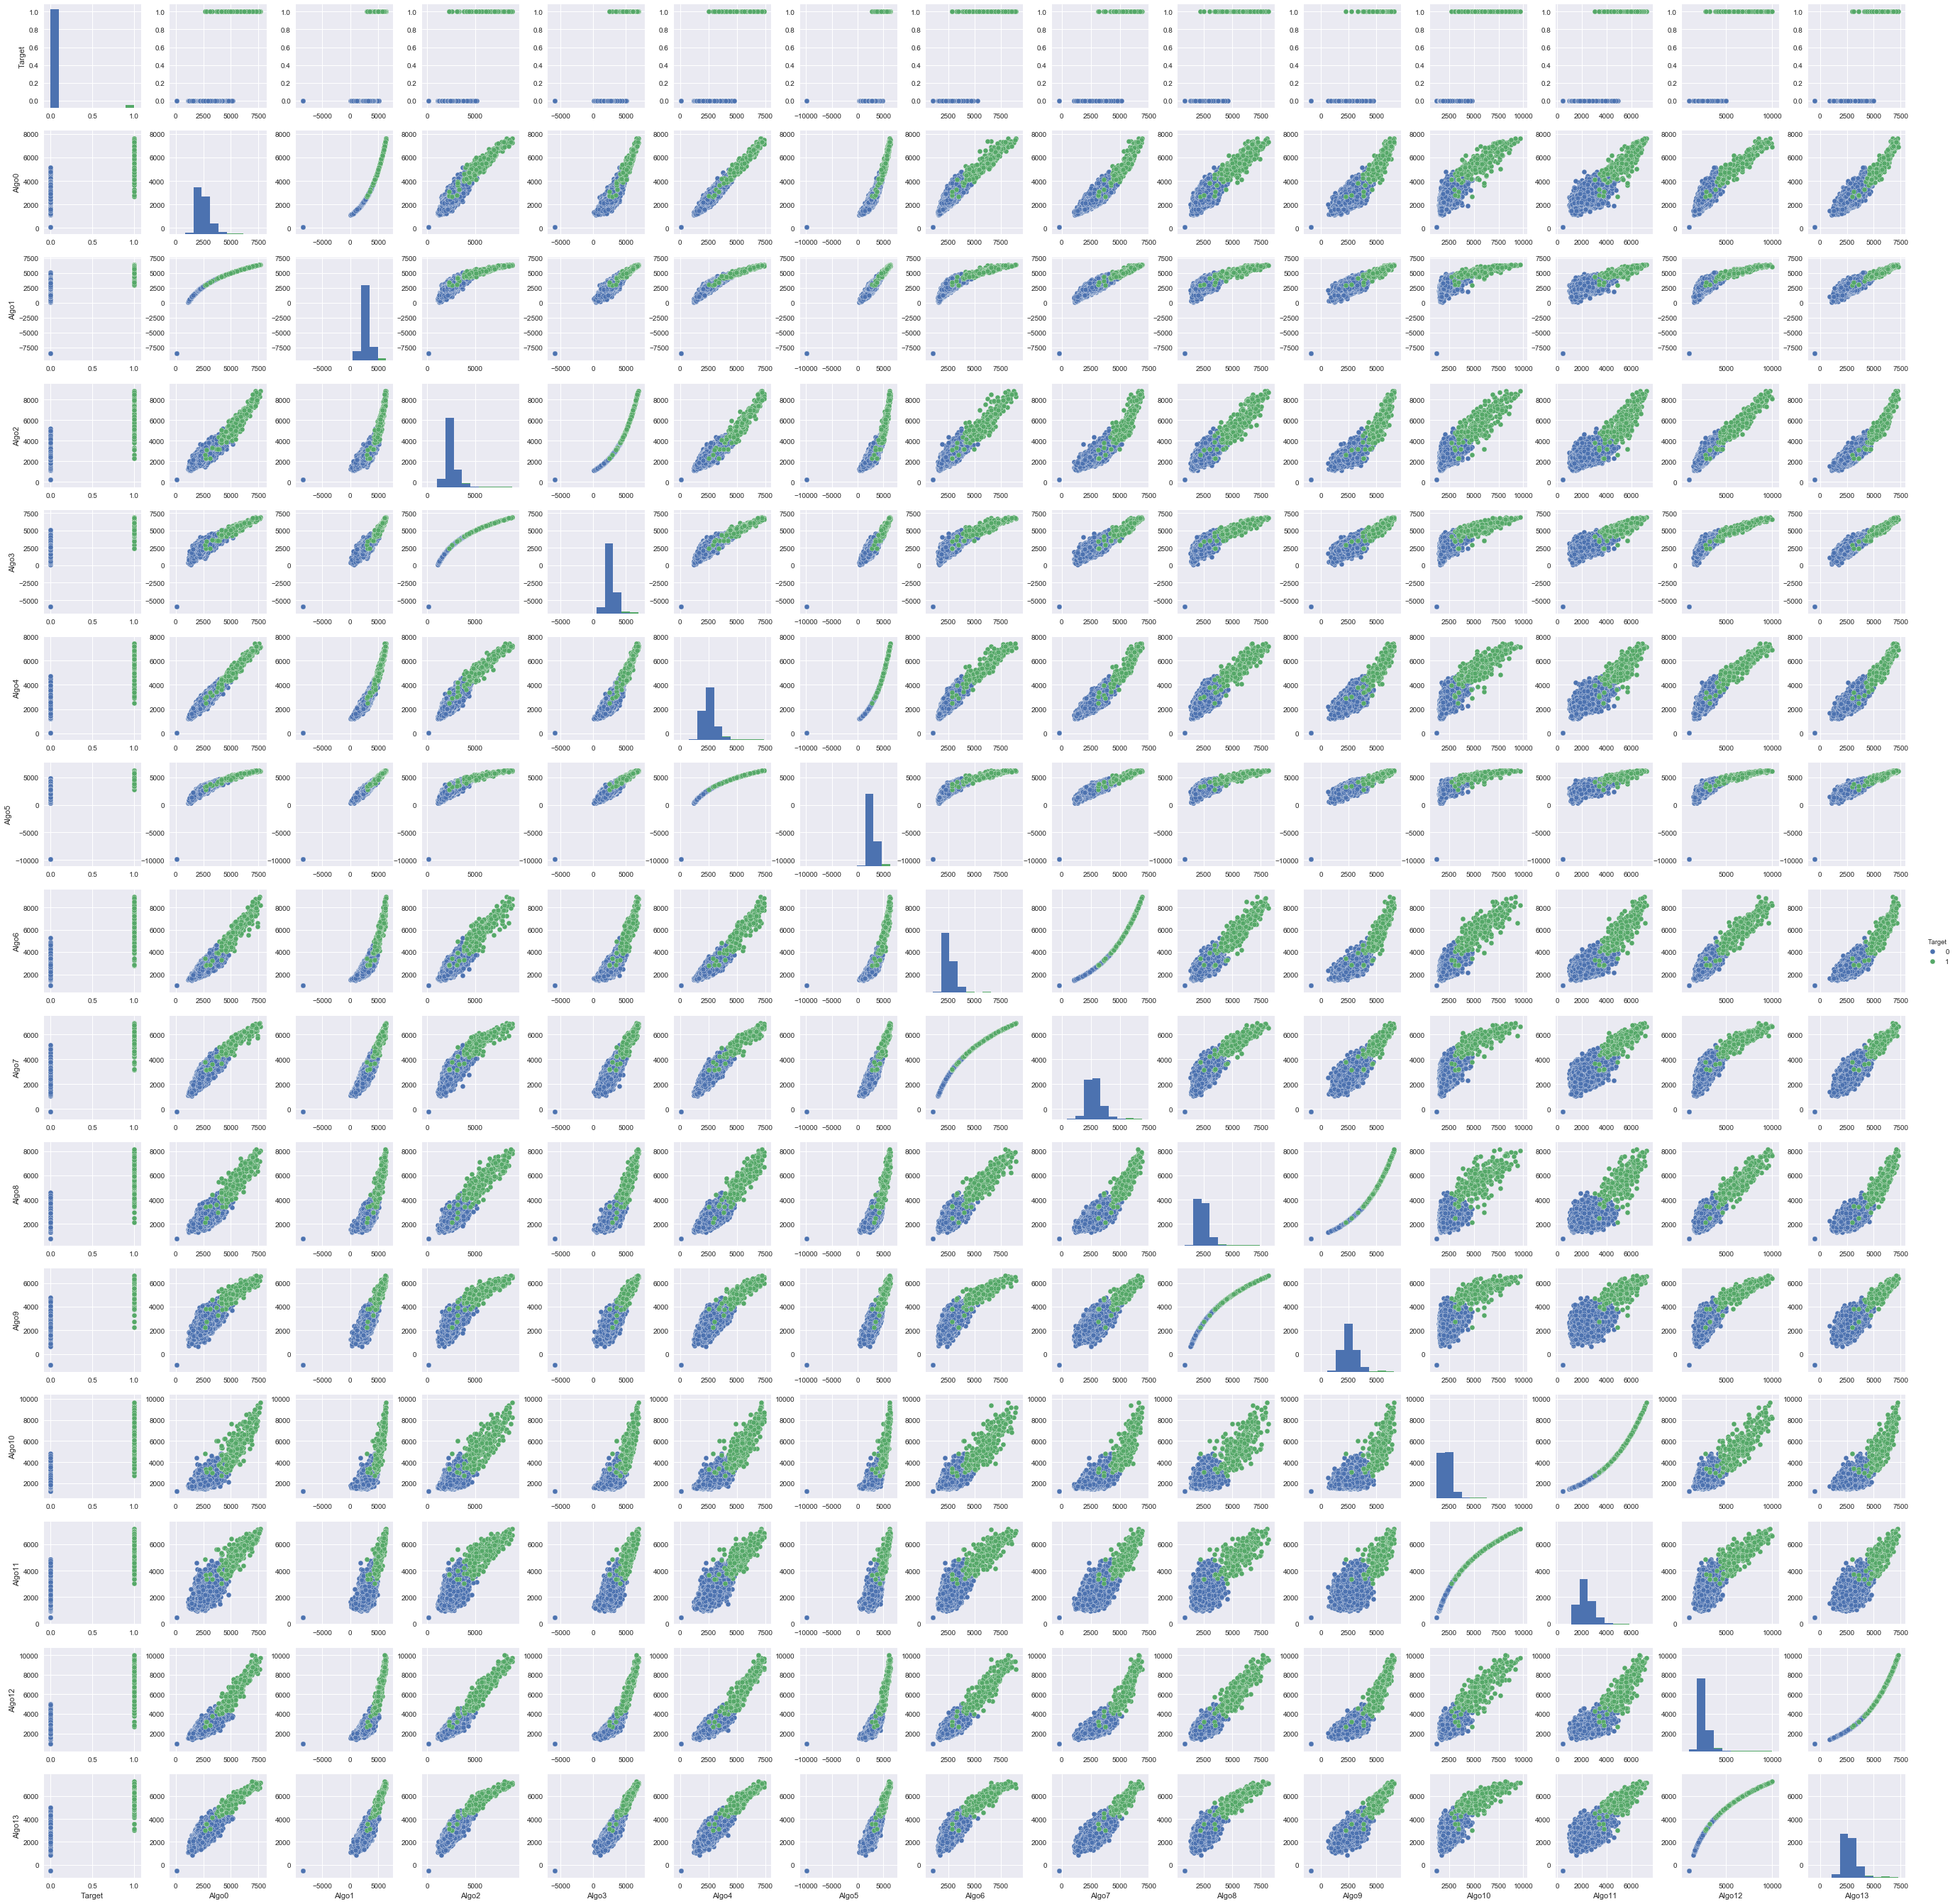

In [11]:
corr_sample = data.sample(frac=0.005, random_state=42)
sns.pairplot(corr_sample, kind="scatter", hue="Target")
plt.show()

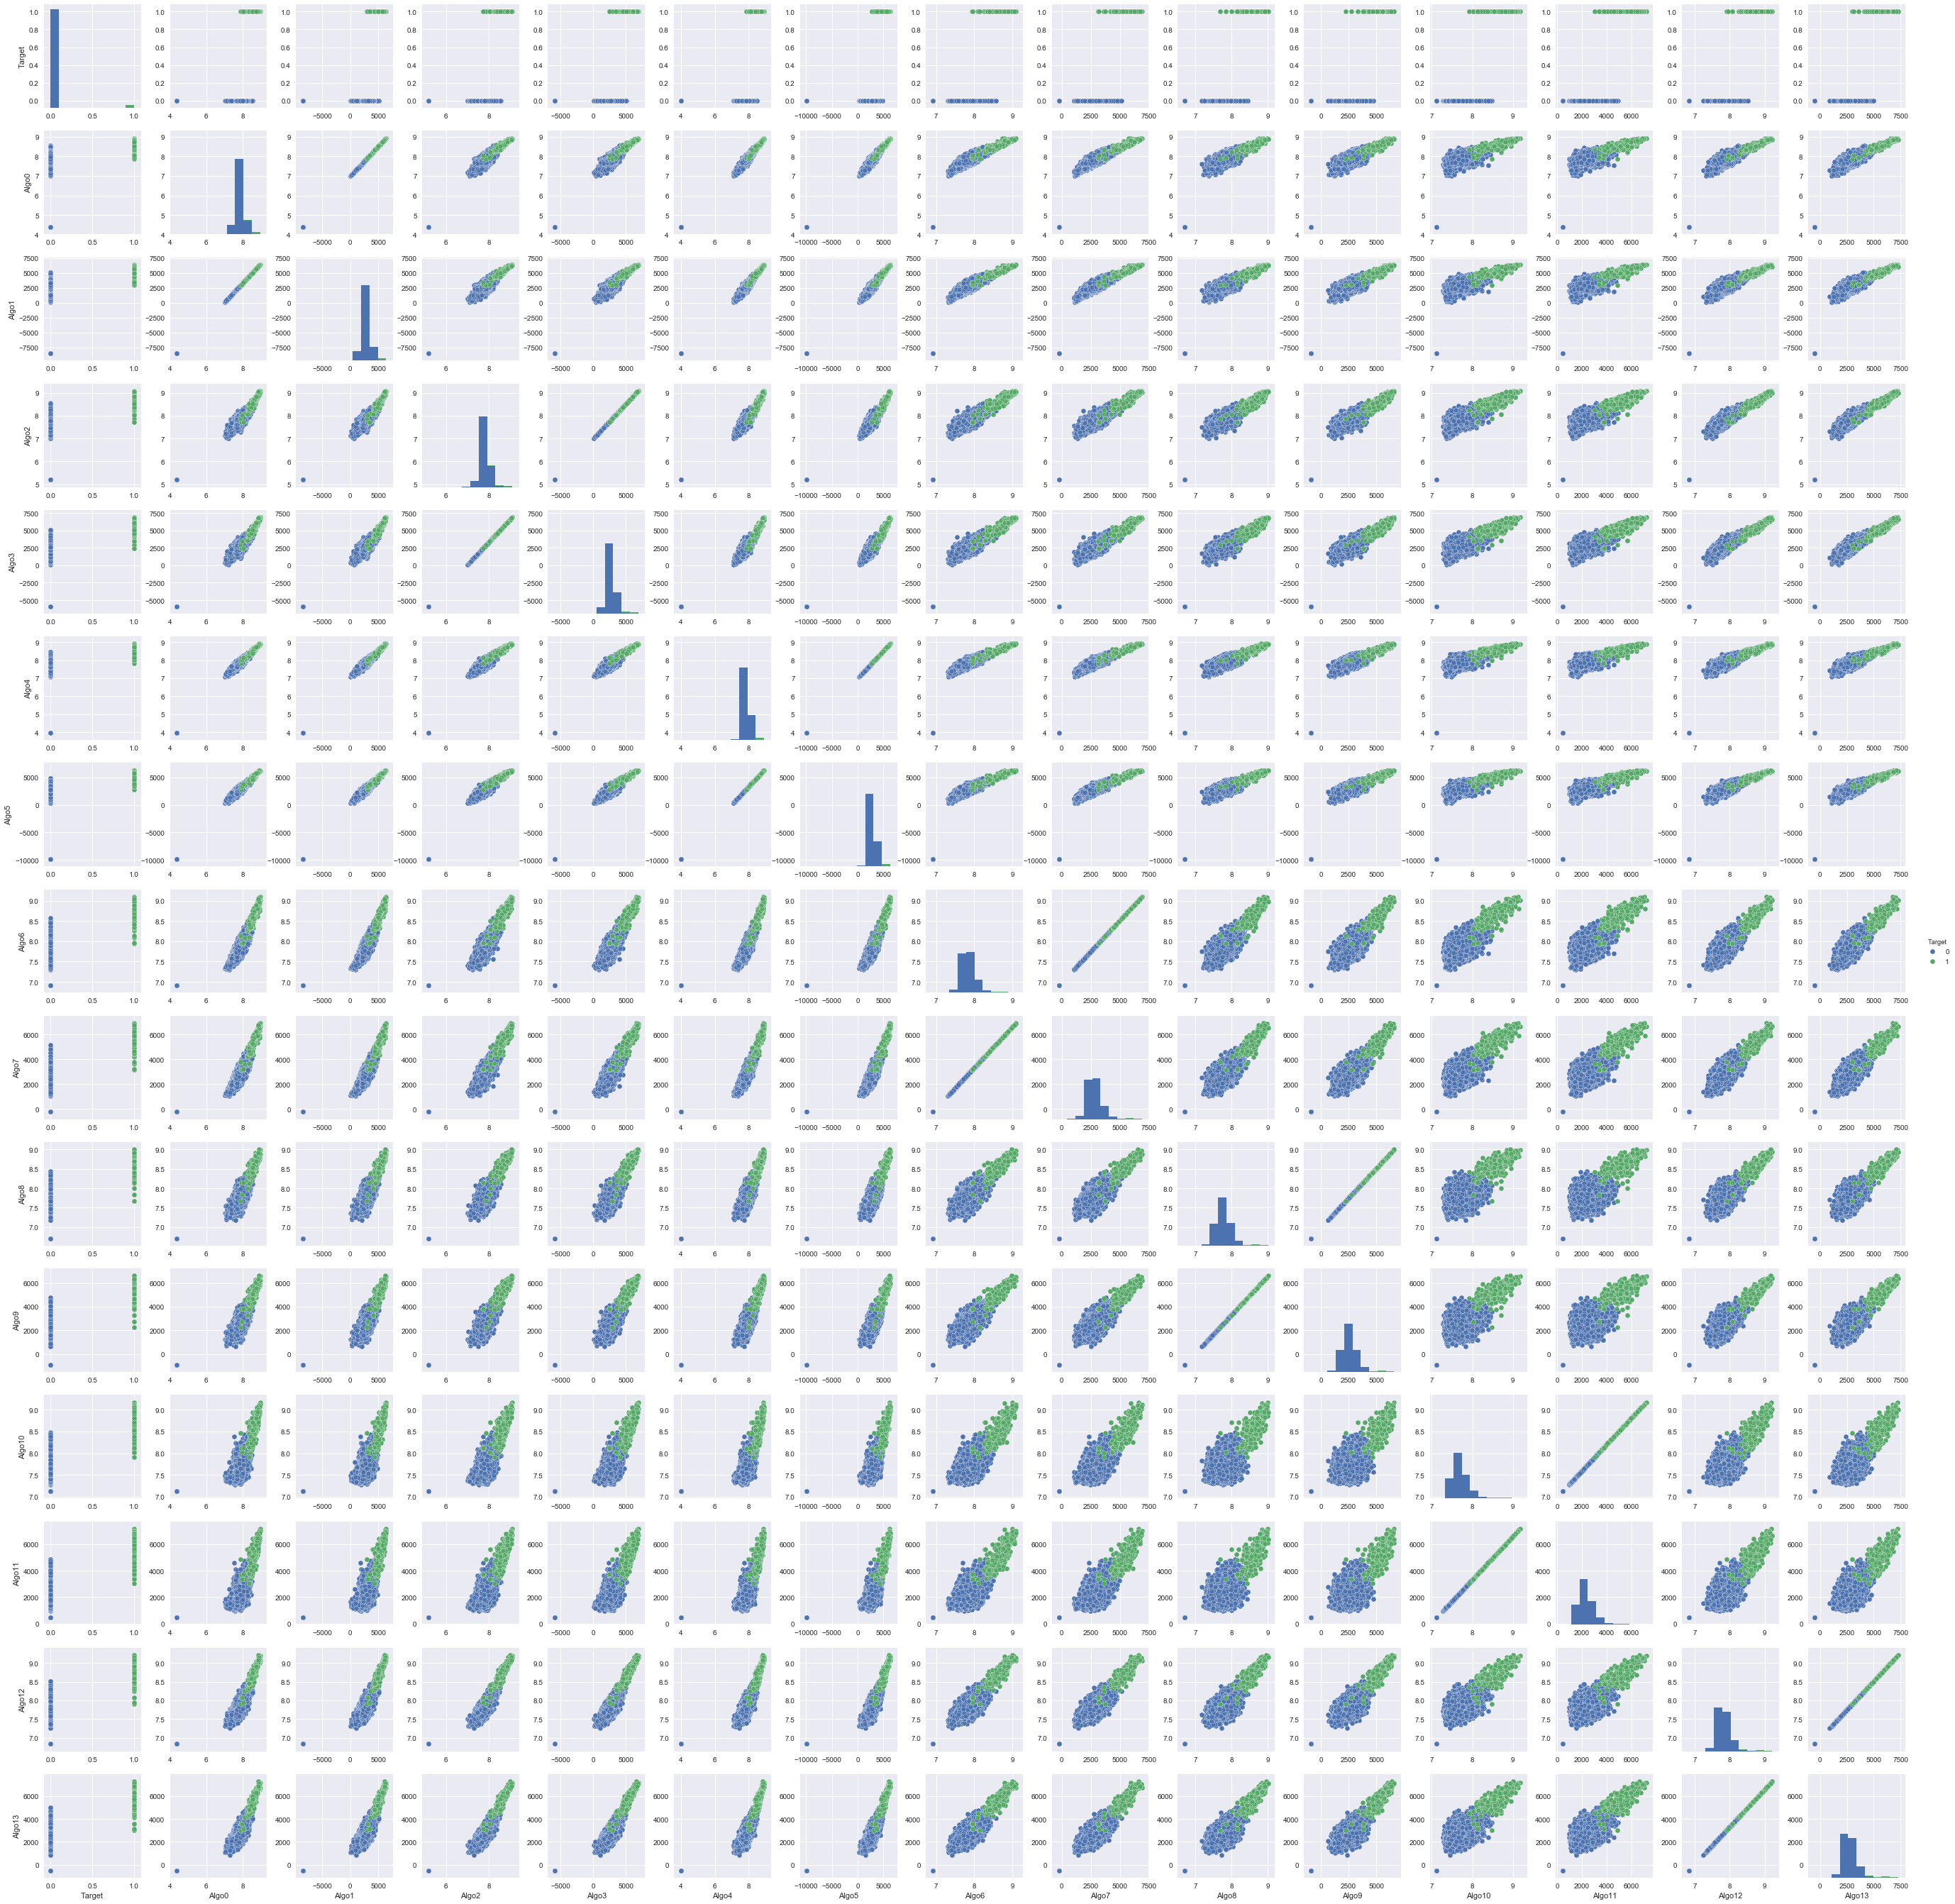

In [12]:
# Vérification de la corrélation entre algorithme pair/impair via une transformation logarithmique
corr_sample_log = data.sample(frac=0.005, random_state=42)
corr_sample_log['Algo0'] = np.log(corr_sample_log['Algo0'])
corr_sample_log['Algo2'] = np.log(corr_sample_log['Algo2'])
corr_sample_log['Algo4'] = np.log(corr_sample_log['Algo4'])
corr_sample_log['Algo6'] = np.log(corr_sample_log['Algo6'])
corr_sample_log['Algo8'] = np.log(corr_sample_log['Algo8'])
corr_sample_log['Algo10'] = np.log(corr_sample_log['Algo10'])
corr_sample_log['Algo12'] = np.log(corr_sample_log['Algo12'])
sns.pairplot(corr_sample_log, kind="scatter", hue="Target")
plt.show()

Complétons avec une heatmap des corrélations entre les différents algorithmes.

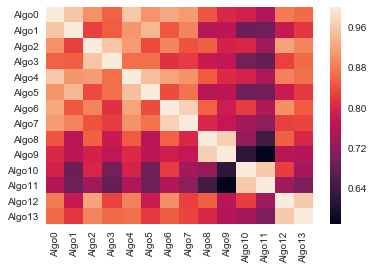

In [13]:
sns.heatmap(corr_sample.iloc[:,1:].corr())
plt.show()

Affichons enfin la distribution des classes pour chaque algorithme à l'aide de boxplots.

/Users/jean-marcsevin/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


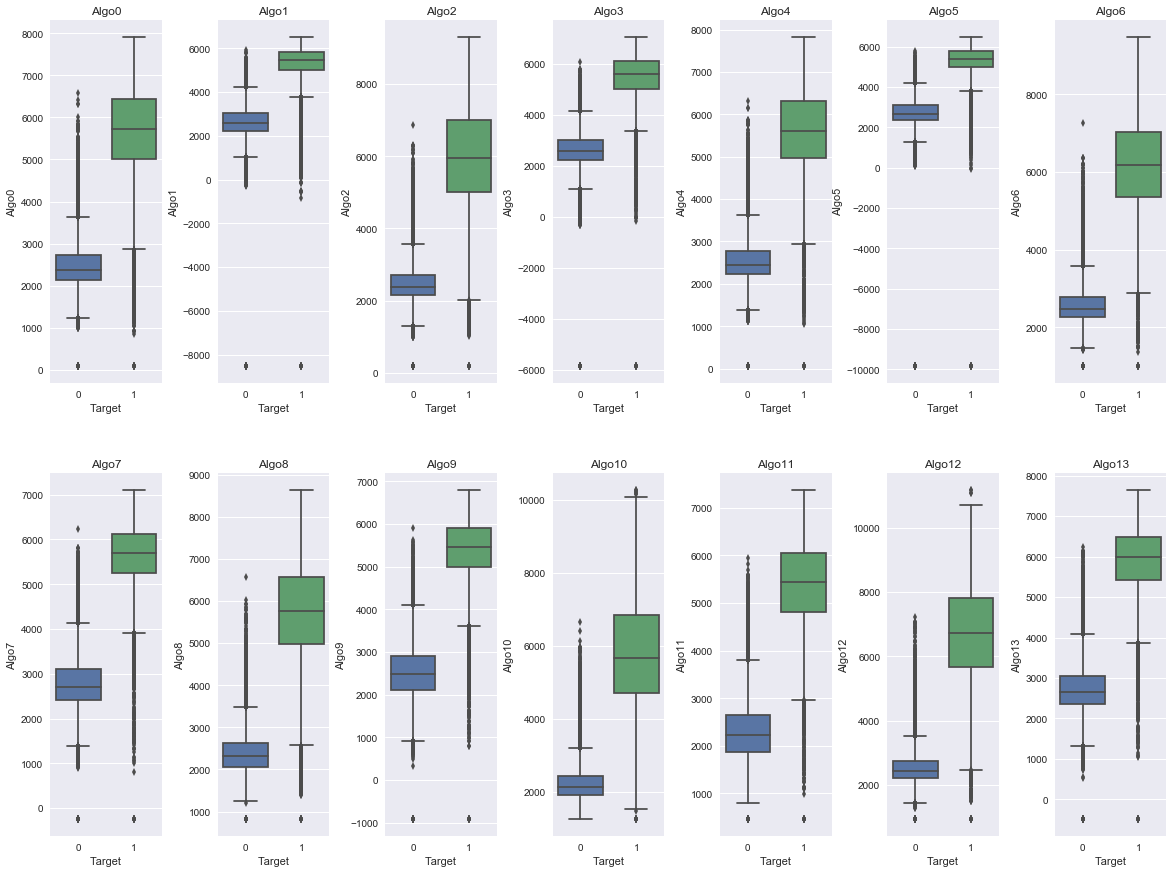

In [14]:
fig = plt.figure(figsize=(20,15))
for i, algo in enumerate(X.columns):
    ax = fig.add_subplot(2,7,i+1)
    sns.boxplot(x="Target", y=algo, data=data)
    plt.title(algo)
plt.subplots_adjust(wspace=0.5,hspace=0.25)

Considérant que les score négatifs sont marginaux, affichons ces distributions en ôtant les scores négatifs.

In [15]:
data_pos = data[data >= 0]
X_pos = data_pos.drop(['Target'], axis=1)
y_pos = data_pos['Target']

/Users/jean-marcsevin/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


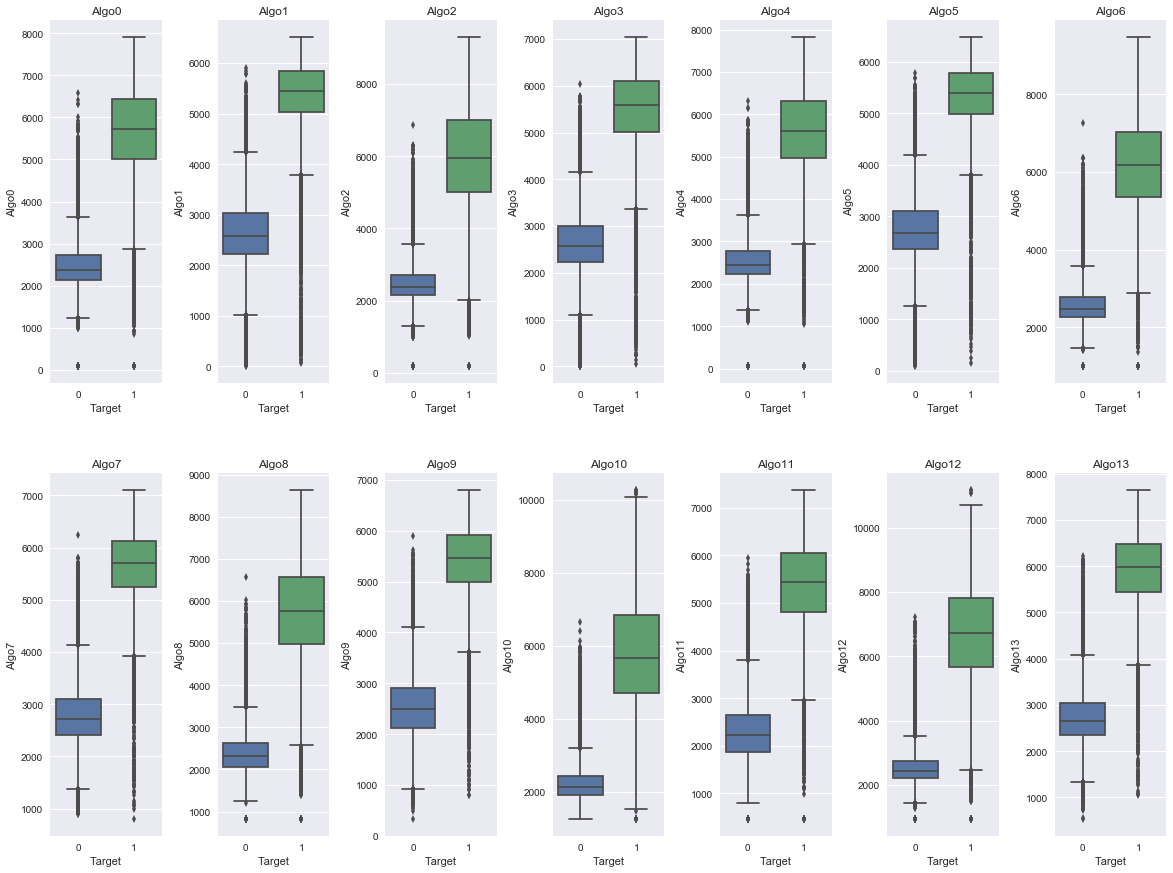

In [16]:
fig = plt.figure(figsize=(20,15))
for i, algo in enumerate(X.columns):
    ax = fig.add_subplot(2,7,i+1)
    sns.boxplot(x="Target", y=algo, data=data_pos)
    plt.title(algo)
plt.subplots_adjust(wspace=0.5,hspace=0.25)

De cette première étape d'exploration, on peut constater plusieurs choses.
* Les paires d'algorithmes pair/impair successives (ex. Algo0 et Algo1) sont toutes dépendantes ; les scores des algorithmes impairs correspondent aux logarithmes des scores des algorithmes pairs après normalisation.
* Les algorithmes 9 et 11 sont les plus décorrélés deux à deux.
* Les algorithmes 7 et 13 semblent être ceux dont les distributions entre les classes positives et négatives se chevauchent le moins.

Observons maintenant la répartition des classes dans le jeu de données fourni.

In [17]:
print('Pourcentage d\'observations négatives :', (data[data['Target']==0].shape[0]/data.shape[0])*100)
print('Pourcentage d\'observations positives :', (data[data['Target']==1].shape[0]/data.shape[0])*100)

Pourcentage d'observations négatives : 97.50751523179713
Pourcentage d'observations positives : 2.49248476820287


Comme on peut le voir, la distribution des données d'apprentissage est très déséquilibrée : on compte moins de 3% d'observations positives. Tentons de comparer la distribution des deux classes.

In [18]:
data[data['Target']==0].describe()

Target         Algo0         Algo1         Algo2         Algo3  \
count  1997772.0  1.997772e+06  1.997772e+06  1.997772e+06  1.997772e+06   
mean         0.0  2.494261e+03  2.666219e+03  2.482704e+03  2.657254e+03   
std          0.0  5.332105e+02  6.767924e+02  5.061991e+02  6.425773e+02   
min          0.0  8.004000e+01 -8.527270e+03  1.802900e+02 -5.867700e+03   
25%          0.0  2.132460e+03  2.222980e+03  2.143260e+03  2.239520e+03   
50%          0.0  2.373470e+03  2.573660e+03  2.379980e+03  2.582630e+03   
75%          0.0  2.729870e+03  3.031830e+03  2.709530e+03  3.007330e+03   
max          0.0  6.578250e+03  5.912240e+03  6.857450e+03  6.048370e+03   

              Algo4         Algo5         Algo6         Algo7         Algo8  \
count  1.997772e+06  1.997772e+06  1.997772e+06  1.997772e+06  1.997772e+06   
mean   2.561888e+03  2.765377e+03  2.575349e+03  2.792220e+03  2.389019e+03   
std    4.975373e+02  6.242943e+02  4.620235e+02  5.565752e+02  4.522421e+02   
min    5.351000e+01 -9.846110e+03  1.002070e+03 -2.503200e+02  8.172000e+02   
25%    2.224030e+03  2.360670e+03  2.259830e+03  2.412980e+03  2.066260e+03   
50%    2.447690e+03  2.674500e+03  2.477980e+03  2.714770e+03  2.312790e+03   
75%    2.782360e+03  3.094210e+03  2.790733e+03  3.104050e+03  2.635950e+03   
max    6.326650e+03  5.784520e+03  7.258590e+03  6.234560e+03  6.560490e+03   

              Algo9        Algo10        Algo11        Algo12        Algo13  
count  1.997772e+06  1.997772e+06  1.997772e+06  1.997772e+06  1.997772e+06  
mean   2.539549e+03  2.221715e+03  2.301521e+03  2.534371e+03  2.738630e+03  
std    5.969178e+02  4.322489e+02  5.910080e+02  4.621316e+02  5.613035e+02  
min   -9.182300e+02  1.244010e+03  4.579500e+02  9.310700e+02 -4.910000e+02  
25%    2.119700e+03  1.915870e+03  1.872220e+03  2.222140e+03  2.357880e+03  
50%    2.488840e+03  2.130500e+03  2.219970e+03  2.438700e+03  2.662450e+03  
75%    2.917170e+03  2.425300e+03  2.644400e+03  2.740760e+03  3.044870e+03  
max    5.903390e+03  6.657530e+03  5.951470e+03  7.241530e+03  6.226850e+03

In [19]:
data[data['Target']==1].describe()

Target         Algo0         Algo1         Algo2         Algo3  \
count  51067.0  51067.000000  51067.000000  51067.000000  51067.000000   
mean       1.0   5677.835470   5365.021935   5958.091635   5484.307718   
std        0.0   1038.208316    702.290965   1394.161727    870.179739   
min        1.0     80.040000  -8527.270000    180.290000  -5867.700000   
25%        1.0   5012.305000   5021.860000   5002.020000   5015.135000   
50%        1.0   5718.170000   5453.350000   5949.290000   5583.120000   
75%        1.0   6447.505000   5846.490000   6997.310000   6114.500000   
max        1.0   7917.510000   6519.120000   9308.740000   7049.270000   

              Algo4         Algo5         Algo6         Algo7         Algo8  \
count  51067.000000  51067.000000  51067.000000  51067.000000  51067.000000   
mean    5587.443008   5319.598226   6171.360128   5636.608647   5730.359597   
std      968.368777    664.257046   1190.088438    680.143185   1142.446883   
min       53.510000  -9846.110000   1002.070000   -250.320000    817.200000   
25%     4963.825000   4990.025000   5363.820000   5243.835000   4970.390000   
50%     5614.090000   5393.190000   6178.760000   5707.060000   5751.580000   
75%     6314.885000   5778.425000   7025.705000   6127.760000   6573.105000   
max     7830.500000   6482.930000   9475.980000   7107.590000   8637.100000   

              Algo9        Algo10        Algo11        Algo12        Algo13  
count  51067.000000  51067.000000  51067.000000  51067.000000  51067.000000  
mean    5387.711971   5800.702309   5384.943945   6729.164377   5895.976459  
std      715.061070   1498.943883    887.643257   1505.386070    796.812678  
min     -918.230000   1244.010000    457.950000    931.070000   -491.000000  
25%     4994.360000   4698.180000   4809.900000   5684.690000   5434.120000  
50%     5472.430000   5676.540000   5429.420000   6726.470000   5985.220000  
75%     5909.680000   6854.940000   6047.175000   7826.290000   6481.175000  
max     6804.020000  10275.370000   7372.830000  11184.690000   7650.540000

Ces deux tableaux semblent confirmer que les classes négatives et positives ont des distributions bien distinctes. Visualisons ces distributions pour chaque algorithme.

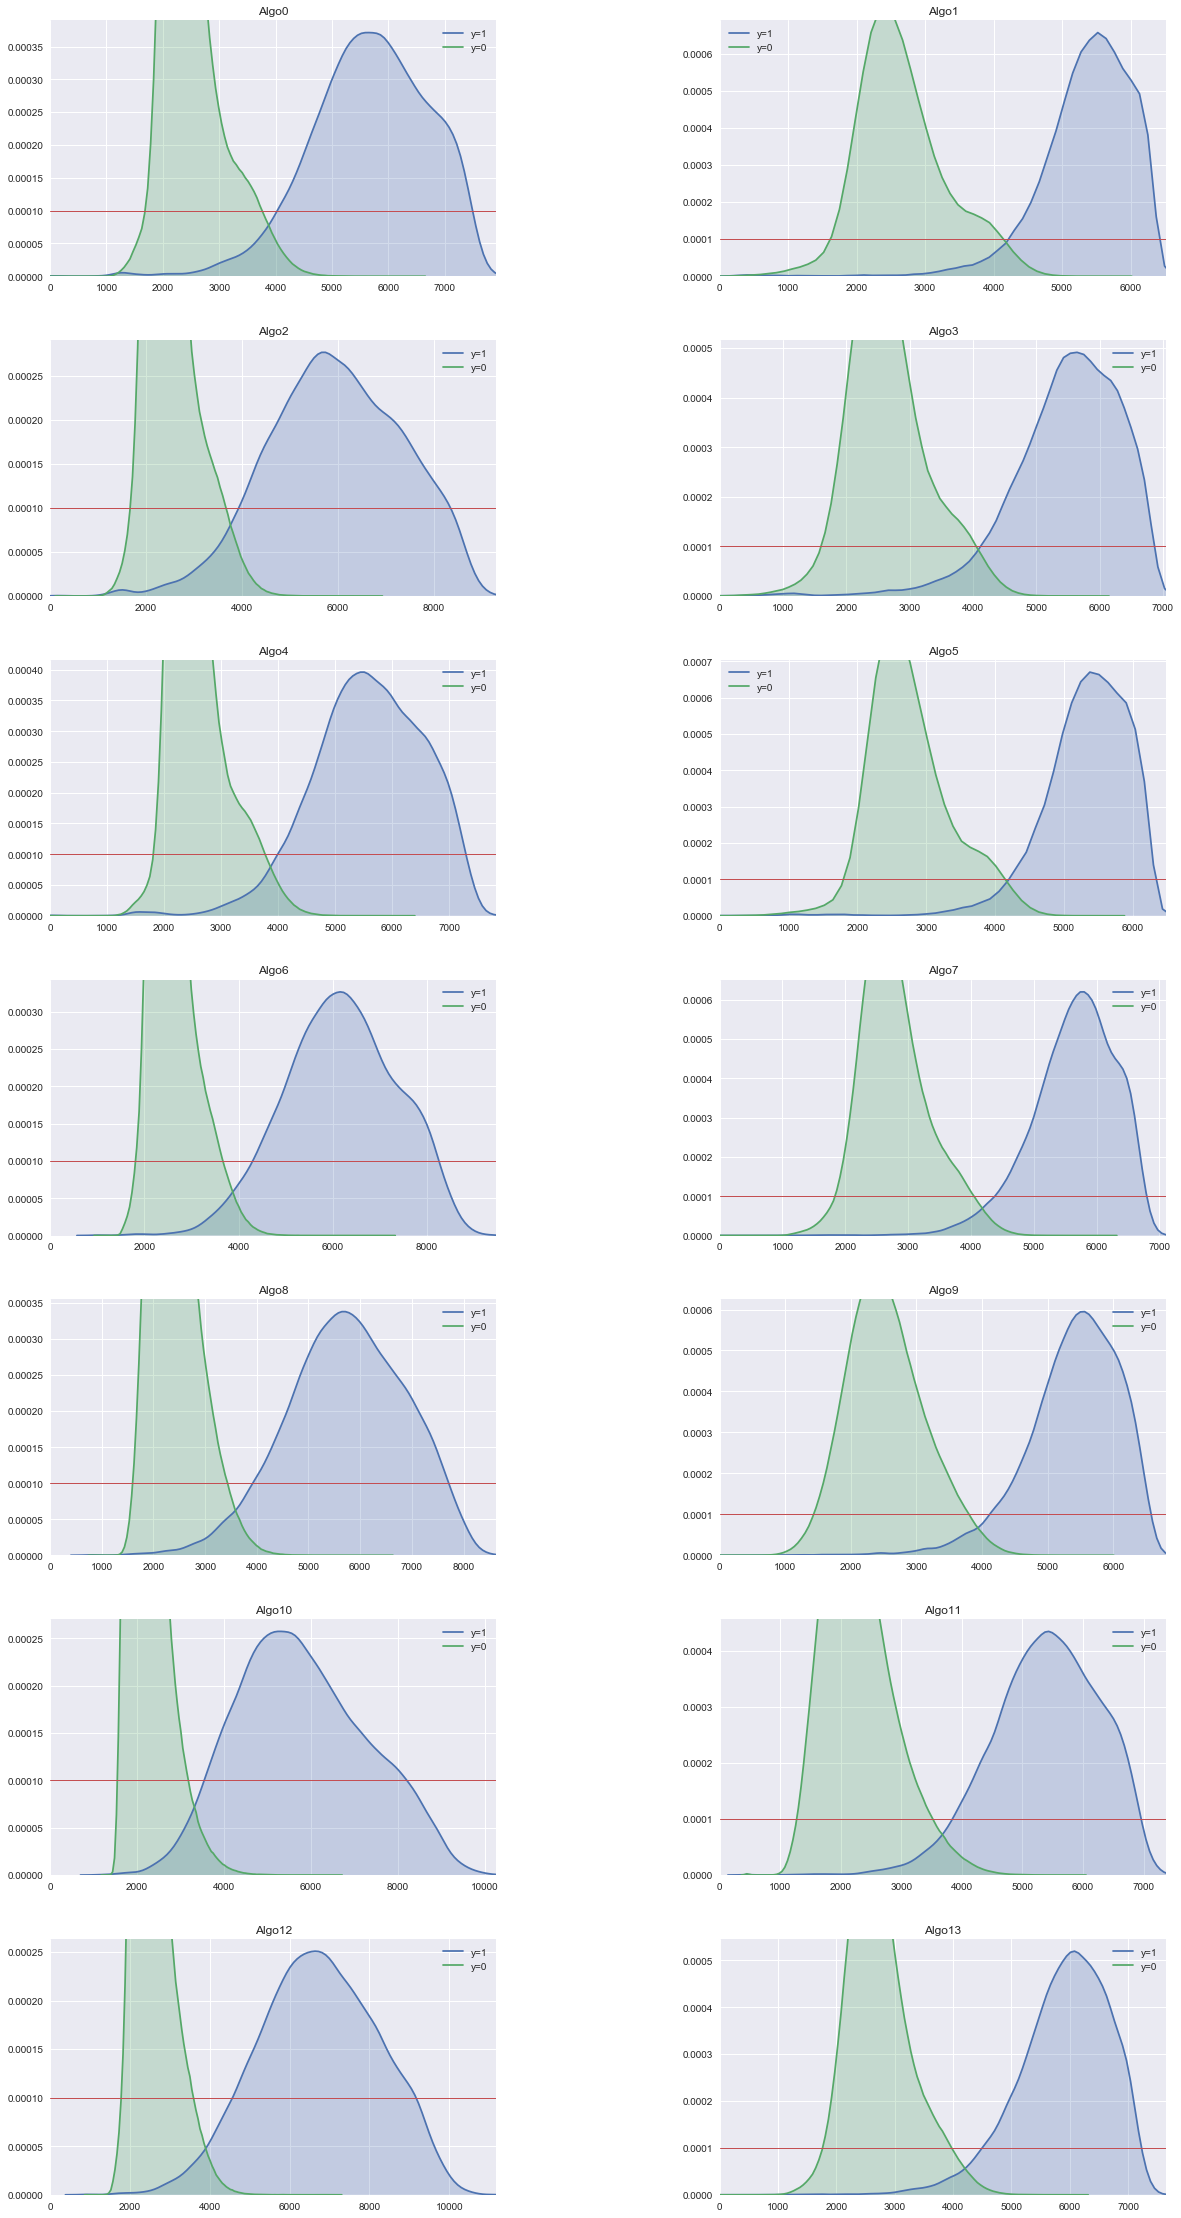

In [20]:
fig = plt.figure(figsize=(20,40))
for i, algo in enumerate(X.columns):
    ax = fig.add_subplot(7,2,i+1)
    ax.set_xlim(0, data[algo].max())
    sns.kdeplot(data[data['Target']==1][algo], shade=True, label="y=1")
    sns.kdeplot(data[data['Target']==0][algo], shade=True, label="y=0")
    plt.plot([0, data[algo].max()], [0.0001, 0.0001], linewidth=1)
    plt.title(algo)
plt.subplots_adjust(wspace=0.5,hspace=0.25)

## Sandbox
Suite à cette phase d'analyse exploratoire, nous allons maintenant explorer successivement les pistes qui paraissent pertinentes pour la modélisation. Au regard des données, je fais le choix de ne garder que les algorithmes impairs. La métrique utilisée pour comparer les résultats de ces différentes pistes sera l'Error Equal Rate (EER), communément utilisée dans les problèmes de fusion de scores, garantissant un optimum entre FAR et FRR.

In [21]:
def compute_eer(ground_truth, predictions):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)
    return eer

Établissons la liste des combinaisons de quatre algorithmes n'excédant pas le temps limite de 600 secondes. On pourrait intégrer les combinaisons de trois algorithmes uniquement, mais celles-ci s'avèreraient moins performantes.

In [22]:
alg_times = {'Algo1': 163, 'Algo3':190, 'Algo5':206, 'Algo7':120, 'Algo9':83, 'Algo11':83, 'Algo13':170}
combinations = []

# Ajout des combinaisons de quatre algorithmes
for comb in itertools.combinations(['Algo1','Algo3','Algo5','Algo7','Algo9','Algo11','Algo13'], 4):
    total_time = 0
    for algo in comb:
        total_time += alg_times[algo]
    if total_time < 600:
        combinations.append(comb)
        
print('Il y a', len(combinations), 'combinaisons possibles.')

Il y a 22 combinaisons possibles.


### Algorithmes simples
Pour référence, commençons avec une régression logistique, appliquée sur toutes les combinaisons linéaires possibles.

In [23]:
# Test Logistic Regression
scores_lr = []

for comb in combinations:
    lr = LogisticRegression(n_jobs=5, random_state=42, solver='saga', max_iter=1000)
    lr.fit(X[list(comb)], y)
    score = compute_eer(y, lr.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    scores_lr.append([comb, score])
    
df_scores_lr = pd.DataFrame(scores_lr, columns=['Combination', 'Score'])
df_scores_lr.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 0.49997577143355343
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 0.5000168719062292
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 0.49952389460413116
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.5000123657418001
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.5000723259890112
('Algo1', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.499843308567677
('Algo1', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.5000323937609669
('Algo1', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.5000022422205573
('Algo1', 'Algo7', 'Algo11', 'Algo13') --- EER: 0.5000271362506318
('Algo1', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.4999012231855847
('Algo3', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.5000136026160481
('Algo3', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.4998559309948986
('Algo3', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.4998105048579166
('Algo3', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.5000268713249083
('Algo3', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.5000272236344124
('Algo3', 

/Users/jean-marcsevin/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


('Algo3', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.4999988477358154
('Algo5', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.49969723470232996
('Algo5', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.49968586878342114
('Algo5', 'Algo7', 'Algo11', 'Algo13') --- EER: 0.4997035045567038
('Algo5', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.4999133999125048
('Algo7', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.5000326441213596


Combination     Score
2    (Algo1, Algo3, Algo9, Algo11)  0.499524
18   (Algo5, Algo7, Algo9, Algo13)  0.499686
17   (Algo5, Algo7, Algo9, Algo11)  0.499697
19  (Algo5, Algo7, Algo11, Algo13)  0.499704
12   (Algo3, Algo5, Algo9, Algo11)  0.499811

Les résultats obtenus avec la régression logistique sont décevants. Testons une Analyse Discriminante Linéaire.

In [24]:
# Test LDA
scores_lda = []

for comb in combinations:
    lda = LinearDiscriminantAnalysis(solver='eigen')
    lda.fit(X[list(comb)], y)
    score = compute_eer(y, lda.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    scores_lda.append([comb, score])
    
df_scores_lda = pd.DataFrame(scores_lda, columns=['Combination', 'Score'])
df_scores_lda.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 0.033265148043921014
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 0.03394244968042029
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 0.031554765737394234
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.030692785910534523
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.03221732669764184
('Algo1', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.030007277783093325
('Algo1', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.029892744445851598
('Algo1', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.03139118198750996
('Algo1', 'Algo7', 'Algo11', 'Algo13') --- EER: 0.030649630289091272
('Algo1', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.029853634433546727
('Algo3', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.03275269491466495
('Algo3', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.03333613108263552
('Algo3', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.031173314136151174
('Algo3', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.02493885937224776
('Algo3', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.026420

Combination     Score
16  (Algo3, Algo9, Algo11, Algo13)  0.024386
13   (Algo3, Algo7, Algo9, Algo11)  0.024939
15  (Algo3, Algo7, Algo11, Algo13)  0.026097
14   (Algo3, Algo7, Algo9, Algo13)  0.026421
21  (Algo7, Algo9, Algo11, Algo13)  0.027262

Puis testons une Analyse Discriminante Quadratique.

In [25]:
# Test QDA
scores_qda = []

for comb in combinations:
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X[list(comb)], y)
    score = compute_eer(y, qda.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    scores_qda.append([comb, score])
    
df_scores_qda = pd.DataFrame(scores_qda, columns=['Combination', 'Score'])
df_scores_qda.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 0.054376557428561546
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 0.045967167307651845
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 0.040323547173464334
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.05462212128126389
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.045912805330546536
('Algo1', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.04083001547494621
('Algo1', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.03545246148653599
('Algo1', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.042936226357298005
('Algo1', 'Algo7', 'Algo11', 'Algo13') --- EER: 0.035352126875448295
('Algo1', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.033683994447703654
('Algo3', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.055227996317551785
('Algo3', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.046371553213087696
('Algo3', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.04033709666803516
('Algo3', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.03704364039370572
('Algo3', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.04203

Combination     Score
16  (Algo3, Algo9, Algo11, Algo13)  0.030866
9   (Algo1, Algo9, Algo11, Algo13)  0.033684
20  (Algo5, Algo9, Algo11, Algo13)  0.034306
15  (Algo3, Algo7, Algo11, Algo13)  0.035217
8   (Algo1, Algo7, Algo11, Algo13)  0.035352

On peut voir que les performances sont correctes et que le rapport entre les distributions des scores positifs et négatifs est bien approché. L'inconvénient de l'Analyse Discriminante Quadratique est qu'elle ne renvoie pas de coefficients permettant de pondérer la formule de fusion des scores. Quant à l'Analyse Discriminante Linéaire, elle nous restreint à une combinaisons linéaire des scores, car l'utilisation de combinaisons quadratiques introduirait de la colinéarité entre les variables et rendrait donc impossible la LDA.

### Algorithmes basés sur les arbres de décision

In [26]:
# Test Decision Tree
scores_dt = []

for comb in combinations:
    dt = DecisionTreeClassifier(max_depth=3, random_state=42, min_samples_leaf=5, class_weight={0: 0.97, 1: 0.03})
    dt.fit(X[list(comb)], y)
    score = compute_eer(y, dt.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    scores_dt.append([comb, score])
    
df_scores_dt = pd.DataFrame(scores_dt, columns=['Combination', 'Score'])
df_scores_dt.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 0.14066693492892593
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 0.14049620859340067
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 0.1371826877891494
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.14066693492892593
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.14689896003578348
('Algo1', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.14524112670838055
('Algo1', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.12984684779891986
('Algo1', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.12751216184398922
('Algo1', 'Algo7', 'Algo11', 'Algo13') --- EER: 0.12763279694820873
('Algo1', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.12462630818965341
('Algo3', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.14066693492892593
('Algo3', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.14689896003578348
('Algo3', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.14453960771791893
('Algo3', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.12984684779891986
('Algo3', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.127512161843989

Combination     Score
9   (Algo1, Algo9, Algo11, Algo13)  0.124626
20  (Algo5, Algo9, Algo11, Algo13)  0.124626
16  (Algo3, Algo9, Algo11, Algo13)  0.124626
21  (Algo7, Algo9, Algo11, Algo13)  0.127512
18   (Algo5, Algo7, Algo9, Algo13)  0.127512

Les arbres de décision étant rapidement sujets au surapprentissage, testons les forêts aléatoires qui permettent de diminuer la variance.

In [27]:
# Test Random Forests
scores_rf = []

for comb in combinations:
    rf = RandomForestClassifier(max_features=2, min_samples_split=2, n_jobs=5, random_state=42, class_weight={0: 0.97, 1: 0.03})
    rf.fit(X[list(comb)], y)
    score = compute_eer(y, rf.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    scores_rf.append([comb, score])
    
df_scores_rf = pd.DataFrame(scores_rf, columns=['Combination', 'Score'])
df_scores_rf.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 0.010962247605578205
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 0.010809037830933949
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 0.00892758434493679
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.01101977111370966
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.010636489668035355
('Algo1', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.008889118207048883
('Algo1', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.008427213241418022
('Algo1', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.009734752401973195
('Algo1', 'Algo7', 'Algo11', 'Algo13') --- EER: 0.009235177125253392
('Algo1', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.007868508009207567
('Algo3', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.01078983306391642
('Algo3', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.010770665038714591
('Algo3', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.008677485303767328
('Algo3', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.008253901894352563
('Algo3', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.009

Combination     Score
16  (Algo3, Algo9, Algo11, Algo13)  0.007560
9   (Algo1, Algo9, Algo11, Algo13)  0.007869
20  (Algo5, Algo9, Algo11, Algo13)  0.008100
21  (Algo7, Algo9, Algo11, Algo13)  0.008119
13   (Algo3, Algo7, Algo9, Algo11)  0.008254

Testons ensuite les Extra Trees.

In [28]:
# Test Extra Trees
scores_et = []

for comb in combinations:
    et = ExtraTreesClassifier(max_features=2, min_samples_split=2, n_jobs=5, random_state=42, class_weight={0: 0.97, 1: 0.03})
    et.fit(X[list(comb)], y)
    score = compute_eer(y, et.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    scores_et.append([comb, score])
    
df_scores_et = pd.DataFrame(scores_et, columns=['Combination', 'Score'])
df_scores_et.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 7.832233557201158e-05
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 7.832233557201158e-05
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 7.832233557201158e-05
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 7.832233557201158e-05
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 7.832233557201158e-05
('Algo1', 'Algo5', 'Algo9', 'Algo11') --- EER: 7.832233557201158e-05
('Algo1', 'Algo7', 'Algo9', 'Algo11') --- EER: 7.832233557201158e-05
('Algo1', 'Algo7', 'Algo9', 'Algo13') --- EER: 7.832233557201158e-05
('Algo1', 'Algo7', 'Algo11', 'Algo13') --- EER: 7.832233557201158e-05
('Algo1', 'Algo9', 'Algo11', 'Algo13') --- EER: 7.832233557201158e-05
('Algo3', 'Algo5', 'Algo7', 'Algo9') --- EER: 7.832233557201158e-05
('Algo3', 'Algo5', 'Algo7', 'Algo11') --- EER: 7.832233557201158e-05
('Algo3', 'Algo5', 'Algo9', 'Algo11') --- EER: 7.832233557201158e-05
('Algo3', 'Algo7', 'Algo9', 'Algo11') --- EER: 7.832233557201158e-05
('Algo3', 'Algo7', 'Algo9', 'Algo13

Combination     Score
0     (Algo1, Algo3, Algo7, Algo9)  0.000078
19  (Algo5, Algo7, Algo11, Algo13)  0.000078
18   (Algo5, Algo7, Algo9, Algo13)  0.000078
17   (Algo5, Algo7, Algo9, Algo11)  0.000078
16  (Algo3, Algo9, Algo11, Algo13)  0.000078

### Algorithmes basés sur les densités

Une autre approche consisterait à se baser sur les densités de probabilités. En effet, lors de la phase d'exploration des données, on a pu noter que les distributions des scores positifs et négatifs étaient bien distinctes, avec une faible zone de superposition ; c'est toutefois cette zone qui nous intéresse. Commençons donc par un modèle de mélange gaussien.

In [29]:
# Test GMM
scores_gmm = []

for comb in combinations:
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(X[list(comb)], y)
    score = compute_eer(y, gmm.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    print('Moyennes:', gmm.means_)
    scores_gmm.append([comb, score])
    
df_scores_gmm = pd.DataFrame(scores_gmm, columns=['Combination', 'Score'])
df_scores_gmm.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 0.10326566829358358
Moyennes: [[2499.17646563 2512.01704941 2664.24871591 2427.91540831]
 [3820.41274348 3728.31960738 3785.62908995 3457.70340101]]
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 0.10177298606471442
Moyennes: [[2499.16815425 2510.59187222 2663.03827926 2186.8492089 ]
 [3885.59731266 3795.296952   3846.87043441 3320.07914786]]
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 0.10215257598970526
Moyennes: [[2498.92319458 2507.90160916 2426.96554619 2186.08109804]
 [3898.03673078 3819.05326757 3521.94028863 3333.06622263]]
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.09573915607001232
Moyennes: [[2509.38789339 2624.80407552 2669.67520727 2435.1621339 ]
 [3821.30491249 3820.44640457 3802.1154393  3461.85587552]]
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.0933215911891335
Moyennes: [[2510.74826664 2625.45119217 2670.22987985 2191.26608968]
 [3891.89427146 3887.86188499 3866.27019076 3351.48162571]]
('Algo1', 'Algo5', 'Alg

Combination     Score
4   (Algo1, Algo5, Algo7, Algo11)  0.093322
5   (Algo1, Algo5, Algo9, Algo11)  0.094707
3    (Algo1, Algo5, Algo7, Algo9)  0.095739
11  (Algo3, Algo5, Algo7, Algo11)  0.096737
12  (Algo3, Algo5, Algo9, Algo11)  0.096814

Même si les scores obtenus semblent correctes, les moyennes des gaussiennes témoignent d'une contre-performance à bien détecter la distribution des classes positives. C'est très certainement dû au déséquilibre des classes dans les données d'apprentissage. Tentons d'y pallier avec un modèle de mélange gaussien permettant d'intégrer cette information.

In [30]:
# Test BGMM
scores_bgmm = []

for comb in combinations:
    bgmm = BayesianGaussianMixture(n_components=2, random_state=42, max_iter=1000)
    bgmm.fit(X[list(comb)], y)
    score = compute_eer(y, bgmm.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    print('Moyennes:', bgmm.means_)
    scores_bgmm.append([comb, score])
    
df_scores_bgmm = pd.DataFrame(scores_bgmm, columns=['Combination', 'Score'])
df_scores_bgmm.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 0.06902067208931881
Moyennes: [[2551.53845479 2556.29188318 2701.47153476 2462.41544148]
 [4017.30063399 3937.28995141 4003.66945822 3655.69428717]]
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 0.08608652208991584
Moyennes: [[2527.70501057 2537.27883789 2684.74317975 2197.23187608]
 [3933.26958834 3838.04945045 3903.09634996 3434.50548086]]
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 0.08762338839600332
Moyennes: [[2525.206563   2532.17406251 2446.65984421 2196.10909424]
 [3955.74622184 3875.23831044 3572.24325625 3447.97352469]]
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.03501216126927327
Moyennes: [[2599.52034396 2705.17007034 2733.44606087 2492.8851521 ]
 [4193.4920353  4179.02455369 4276.30049825 3892.77493644]]
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.0681850335873755
Moyennes: [[2553.27636857 2663.69309634 2702.12126571 2210.75592821]
 [4007.65414068 3998.12522172 4001.42217797 3563.51622094]]
('Algo1', 'Algo5', 'Alg

Combination     Score
3    (Algo1, Algo5, Algo7, Algo9)  0.035012
18  (Algo5, Algo7, Algo9, Algo13)  0.058646
10   (Algo3, Algo5, Algo7, Algo9)  0.062489
7   (Algo1, Algo7, Algo9, Algo13)  0.067492
4   (Algo1, Algo5, Algo7, Algo11)  0.068185

In [31]:
bgmm = BayesianGaussianMixture(n_components=2, random_state=42, max_iter=1000)
bgmm.fit(X[['Algo1', 'Algo5', 'Algo7', 'Algo9']], y)
print('Poids:', bgmm.weights_)

Poids: [0.91595515 0.08404485]


Bien que plus proche des vraies moyennes que la modélisation précédente, celle-ci présente toujours des performances inférieures aux forêts aléatoires. Par ailleurs, on ne peut pas en tirer rapidement les coefficients qui nous intéressent pour construire la matrice de fusion.

### Passage aux variables quadratiques
Reprenons les forêts aléatoires en y intégrant maintenant les combinaisons quadratiques des scores.

In [32]:
# Test Random Forests (Quadratic version)
scores_rfq = []

for comb in combinations:
    poly = PolynomialFeatures(2)
    rfq = RandomForestClassifier(max_features=2, min_samples_split=2, n_jobs=5, random_state=42, class_weight={0: 0.97, 1: 0.03})
    pipeline = Pipeline([("poly", poly), ("clf", rfq)])
    pipeline.fit(X[list(comb)], y)
    score = compute_eer(y, pipeline.predict(X[list(comb)]))
    print(comb, '--- EER:', score)
    scores_rfq.append([comb, score])
    
df_scores_rfq = pd.DataFrame(scores_rfq, columns=['Combination', 'Score'])
df_scores_rfq.sort_values('Score').head()

('Algo1', 'Algo3', 'Algo7', 'Algo9') --- EER: 0.010885635387752063
('Algo1', 'Algo3', 'Algo7', 'Algo11') --- EER: 0.010828140135673544
('Algo1', 'Algo3', 'Algo9', 'Algo11') --- EER: 0.008831349794715379
('Algo1', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.0112878081810292
('Algo1', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.010904799024892593
('Algo1', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.009062189766590106
('Algo1', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.008099748536260252
('Algo1', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.009581070024480148
('Algo1', 'Algo7', 'Algo11', 'Algo13') --- EER: 0.009158281337228688
('Algo1', 'Algo9', 'Algo11', 'Algo13') --- EER: 0.00796487240358536
('Algo3', 'Algo5', 'Algo7', 'Algo9') --- EER: 0.010636521274161231
('Algo3', 'Algo5', 'Algo7', 'Algo11') --- EER: 0.010579018331306629
('Algo3', 'Algo5', 'Algo9', 'Algo11') --- EER: 0.008561972268439754
('Algo3', 'Algo7', 'Algo9', 'Algo11') --- EER: 0.00817682490351361
('Algo3', 'Algo7', 'Algo9', 'Algo13') --- EER: 0.0091

Combination     Score
16  (Algo3, Algo9, Algo11, Algo13)  0.007367
9   (Algo1, Algo9, Algo11, Algo13)  0.007965
6    (Algo1, Algo7, Algo9, Algo11)  0.008100
21  (Algo7, Algo9, Algo11, Algo13)  0.008119
13   (Algo3, Algo7, Algo9, Algo11)  0.008177

La meilleure combinaison semble donc être **(Algo3, Algo9, Algo11, Algo13)**, mais nous conserverons également la combinaison **(Algo7, Algo9, Algo11, Algo13)** étant donné qu'elle était ressortie de l'analyse des données.

## Calcul de la matrice de fusion

In [33]:
# Calcul pour la combinaison (Algo3, Algo9, Algo11, Algo13)
poly = PolynomialFeatures(2)
rfq = RandomForestClassifier(max_features=2, min_samples_split=2, n_jobs=5, random_state=42, class_weight={0: 0.97, 1: 0.03})
pipeline = Pipeline([("poly", poly), ("clf", rfq)])
pipeline.fit(X[['Algo3', 'Algo9', 'Algo11', 'Algo13']], y)
rfq.feature_importances_

array([0.        , 0.01287767, 0.02061095, 0.01342329, 0.01569677,
       0.01135239, 0.16959088, 0.08387931, 0.01382251, 0.02004508,
       0.10810524, 0.17484465, 0.01277441, 0.25372693, 0.08924993])

In [34]:
# Calcul pour la combinaison (Algo7, Algo9, Algo11, Algo13)
poly = PolynomialFeatures(2)
rfq = RandomForestClassifier(max_features=2, min_samples_split=2, n_jobs=5, random_state=42, class_weight={0: 0.97, 1: 0.03})
pipeline = Pipeline([("poly", poly), ("clf", rfq)])
pipeline.fit(X[['Algo7', 'Algo9', 'Algo11', 'Algo13']], y)
rfq.feature_importances_

array([0.        , 0.01430048, 0.01807464, 0.01341315, 0.01049763,
       0.01720028, 0.2629576 , 0.08838932, 0.01521891, 0.01553717,
       0.09793761, 0.17473419, 0.01210961, 0.17247163, 0.08715777])

In [35]:
# Construction de la matrice de fusion pour la combinaison (Algo3, Algo9, Algo11, Algo13)
M1 = np.zeros((15,15))
M1[0,3] = 0.01287767
M1[0,9] = 0.02061095
M1[0,11] = 0.01342329
M1[0,13] = 0.01569677
M1[3,3] = 0.01135239
M1[3,9] = 0.16959088
M1[3,11] = 0.08387931
M1[3,13] = 0.01382251
M1[9,9] = 0.02004508
M1[9,11] = 0.10810524
M1[9,13] = 0.17484465
M1[11,11] = 0.01277441
M1[11,13] = 0.25372693
M1[13,13] = 0.08924993

In [36]:
# Construction de la matrice de fusion pour la combinaison (Algo7, Algo9, Algo11, Algo13)
M2 = np.zeros((15,15))
M2[0,7] = 0.01430048
M2[0,9] = 0.01807464
M2[0,11] = 0.01341315
M2[0,13] = 0.01049763
M2[7,7] = 0.01720028
M2[7,9] = 0.2629576
M2[7,11] = 0.08838932
M2[7,13] = 0.01521891
M2[9,9] = 0.01553717
M2[9,11] = 0.09793761
M2[9,13] = 0.17473419
M2[11,11] = 0.01210961
M2[11,13] = 0.172471633
M2[13,13] = 0.08715777

In [37]:
# Scripts for submission

# Running time of each algorithm (in milliseconds)
alg_times = np.zeros((14,1))
alg_times[0] = 163
alg_times[1] = 163
alg_times[2] = 190
alg_times[3] = 190
alg_times[4] = 206
alg_times[5] = 206
alg_times[6] = 120
alg_times[7] = 120
alg_times[8] = 83
alg_times[9] = 83
alg_times[10] = 83
alg_times[11] = 83
alg_times[12] = 170
alg_times[13] = 170

# Time constraint: The total duration of the algorithms cannot exceed 600 milliseconds
alg_time_thr = 600

# Compute the total computational time for the fusion algorithm
def compute_total_time(M):
    is_used = np.zeros((14,1))
    for i in range(15):
        for j in range(15):
            if(M[i,j] != 0):
                if(i>=1):
                    is_used[i-1] = 1
                if(j>=1):
                    is_used[j-1] = 1

    total_dur = np.dot(is_used.T,alg_times)
    return total_dur[0,0]

# Evaluation metric
def compute_eval(fused_score):
    look_at_FAR = 0.0001
    # calculating FAR and FRR
    sort = np.argsort(fused_score[:,1])

    #sort = np.concatenate([sort[-2:],sort[:-2]], axis=0)
    scores = fused_score[sort]
    totpos = sum(scores[:,0])
    totneg = scores.shape[0]-totpos
    fa = (np.cumsum(scores[:,0]-1)+totneg)/totneg
    fr = np.cumsum(scores[:,0])/totpos

    i=0
    while fa[i]>look_at_FAR:
        i+=1

    return scores[i][1], fa[i], fr[i]

# Load the data

train_fname = 'train15_telecom.txt'
train_data = np.loadtxt(train_fname, dtype=np.float) #The first column contains the labels, the rest of the columns contains the scores

# Extract the labels
y_trn = train_data[:,0].astype(int)

# Extract the score vectors
s_trn = train_data.copy()
# Put a 1 in front of all the scores (see the "Fusion method" section above)
s_trn[:,0] = 1;

In [38]:
# Evaluation pour la combinaison (Algo3, Algo9, Algo11, Algo13)

cur_s = s_trn[0]
cur_s_hat = np.dot(cur_s.T,np.dot(M1,cur_s)) 

#Check if the time constraint is satisfied:

tot_dur = compute_total_time(M1)
print(tot_dur)

if(tot_dur <= alg_time_thr):
    print("The total running time of the fusion is acceptable!")
else:
    print("The total running time of the fusion is NOT acceptable!")

#Evaluation

#apply fusion on scores  
fuse = np.multiply(s_trn[:,None,:]*s_trn[:,:,None], M1)
fuse = np.concatenate([np.reshape(y_trn, [-1,1]), np.reshape(np.sum(fuse, axis=(1,2)), [-1,1])], axis=1)
fuse[np.isnan(fuse)]=-float("inf")

look_at_FAR = 0.0001

#compute the FRR at FAR = 0.01%
thr, fa, fr = compute_eval(fuse)

print("Score at FAR="+str(look_at_FAR*100.0)+"%")
print("threshold :", thr, "far :",fa, "frr :", fr)

526.0
The total running time of the fusion is acceptable!


/Users/jean-marcsevin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


Score at FAR=0.01%
threshold : 18592171.74104835 far : 9.9610468009022e-05 frr : 0.09657143976033365


In [39]:
# Evaluation pour la combinaison (Algo7, Algo9, Algo11, Algo13)

cur_s = s_trn[0]
cur_s_hat = np.dot(cur_s.T,np.dot(M2,cur_s)) 

#Check if the time constraint is satisfied:

tot_dur = compute_total_time(M2)
print(tot_dur)

if(tot_dur <= alg_time_thr):
    print("The total running time of the fusion is acceptable!")
else:
    print("The total running time of the fusion is NOT acceptable!")

#Evaluation

#apply fusion on scores  
fuse = np.multiply(s_trn[:,None,:]*s_trn[:,:,None], M2)
fuse = np.concatenate([np.reshape(y_trn, [-1,1]), np.reshape(np.sum(fuse, axis=(1,2)), [-1,1])], axis=1)
fuse[np.isnan(fuse)]=-float("inf")

look_at_FAR = 0.0001

#compute the FRR at FAR = 0.01%
thr, fa, fr = compute_eval(fuse)

print("Score at FAR="+str(look_at_FAR*100.0)+"%")
print("threshold :", thr, "far :",fa, "frr :", fr)

456.0
The total running time of the fusion is acceptable!


/Users/jean-marcsevin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


Score at FAR=0.01%
threshold : 18556258.206094578 far : 9.9610468009022e-05 frr : 0.08347202913590883


C'est finalement la combinaison **(Algo7, Algo9, Algo11, Algo13)** qui s'avère la plus performante ; nous conserverons donc celle-ci pour générer les prédictions.

Vous ne trouverez pas d'étapes Grid Search ou Cross Validation dans ce Notebook. En effet, bien qu'ayant effectué plusieurs essais dans ce sens, sous la forme de brouillons, le FRR obtenu a toujours oscillé autour de 0.08, sans progrès particulièrement notable.